## RetinaNet 模型训练 

In [1]:
!wget https://pinlandata.blob.core.windows.net/pinlan-data-hub/%E5%A4%96%E5%8C%85%E9%87%87%E9%9B%86/0523%E6%A3%80%E6%B5%8B%E6%95%B0%E6%8D%AE/detdata_baijiu_train.zip

Incomplete or invalid multibyte sequence encountered
--2021-09-06 19:37:52--  https://pinlandata.blob.core.windows.net/pinlan-data-hub/%E5%A4%96%E5%8C%85%E9%87%87%E9%9B%86/0523%E6%A3%80%E6%B5%8B%E6%95%B0%E6%8D%AE/detdata_baijiu_train.zip
Resolving pinlandata.blob.core.windows.net (pinlandata.blob.core.windows.net)... 52.239.128.36
Connecting to pinlandata.blob.core.windows.net (pinlandata.blob.core.windows.net)|52.239.128.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 220598056 (210M) [application/zip]
Saving to: 'detdata_baijiu_train.zip'

detdata_baijiu_trai 100%[===================>] 210.38M  1.06MB/s    in 3m 5s   

2021-09-06 19:40:58 (1.14 MB/s) - 'detdata_baijiu_train.zip' saved [220598056/220598056]



In [4]:
!mv detdata_baijiu_train.zip data/

In [5]:
!unzip data/detdata_baijiu_train.zip

## 划分数据集

In [1]:
data_dir = 'data/baijiu'
result_model_path = 'models/'
ratio = 0.1

In [3]:
import os
import subprocess

# 开始运行程序
# 数据准备
data_prep_command_line = ['python', 'data_prep/split_data.py', '--data_dir', data_dir, '--ratio', str(ratio),]
print('\n开始分离训练集和验证集')
process = subprocess.Popen(data_prep_command_line)
process.wait()
if process.returncode != 0:
    print(f"分离训练集和验证集失败，失败码：{process.returncode}")
else:
    print('分离训练集和验证集成功')


开始分离训练集和验证集
分离训练集和验证集成功


In [6]:
#!python data_prep/split_data.py --data_dir data/baijiu --ratio 0.1

## 生成CSV格式数据集和标注

In [4]:
# 生成 csv
gen_csv_command_line = ['python', 'data_prep/gen_csv.py', '--data_dir', data_dir,]
print('\n开始生成 csv 文件')
process = subprocess.Popen(gen_csv_command_line)
process.wait()
if process.returncode != 0:
    print(f"生成 csv 文件失败，失败码：{process.returncode}")
else:
    print('生成 csv 文件成功')


开始生成 csv 文件
生成 csv 文件成功


In [ ]:
#!python data_prep/gen_csv.py --data_dir data/baijiu

## 训练模型

In [ ]:
import os
import subprocess

# 训练模型
train_csv_path = os.path.join(data_dir, 'train_data.csv')
val_csv_path = os.path.join(data_dir, 'val_data.csv')
class_csv_path = os.path.join(data_dir, 'class.csv')
train_log_path = 'logs/train_info.txt'

if os.path.exists(train_log_path):
    os.remove(train_log_path)
    
train_log = open(train_log_path, 'a')

train_command_line = ['python', 
                      'keras-retinanet/keras_retinanet/bin/train.py', 
                      '--snapshot-path', result_model_path, 
                      'csv', train_csv_path, class_csv_path, 
                      '--val-annotations', val_csv_path,
                     ]
print('\n开始训练...')
process = subprocess.Popen(train_command_line, stdout=train_log, stderr=train_log)
process.wait()
if process.returncode != 0:
    print(f"训练失败，失败码：{process.returncode}")
else:
    print('训练完成!')

In [ ]:
# !python keras-retinanet/keras_retinanet/bin/train.py --snapshot-path models csv data/baijiu/train_data.csv data/baijiu/class.csv --val-annotations data/baijiu/val_data.csv

## 转换前向模型

In [10]:
trained_model_path = 'models/resnet50_csv_20.h5'
inference_model_save_path = "models/RetinaNet/retinanet_inference.h5"

In [12]:
import subprocess

convert_command = ['python', 'keras-retinanet/keras_retinanet/bin/convert_model.py', '--no-class-specific-filter', trained_model_path, inference_model_save_path]
print('开始模型转换...')
process = subprocess.Popen(convert_command)
process.wait()
if process.returncode != 0:
    print(f"模型转换失败，失败码：{process.returncode}")
else:
    print('模型转换成功!')

开始模型转换...
模型转换成功!


## 使用 GPU 推理

In [8]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# use this to change which GPU to use
# gpu = 0

# set the modified tf session as backend in keras
# setup_gpu(gpu)

In [23]:
from tensorflow import keras as keras
from PIL import Image

import tensorflow as tf
import numpy as np

keras.backend.clear_session()  # For easy reset of notebook state.

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.set_visible_devices(devices=gpus[0], device_type="GPU")

## 加载类别标注

In [14]:
!pip install pandas

Looking in indexes: https://repo.huaweicloud.com/repository/pypi/simple/
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.


In [5]:
import pandas as pd

df = pd.read_csv("data/baijiu/class.csv", header=None)

# load label to names mapping for visualization purposes
labels_to_names = df[0].values.tolist()

In [6]:
df[0].values.tolist()

['box', 'others', 'bucket', 'bottle', 'bag', 'jar']

## 加载 RetinaNet 模型

In [12]:
model = models.load_model(inference_model_save_path, backbone_name='resnet50')

print(model.summary())

Model: "retinanet-bbox"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9408        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (Activation)         (None, None, None, 6 0           bn_conv1[0][0]                   
_____________________________________________________________________________________

## 测试单张效果

processing time:  0.07663297653198242


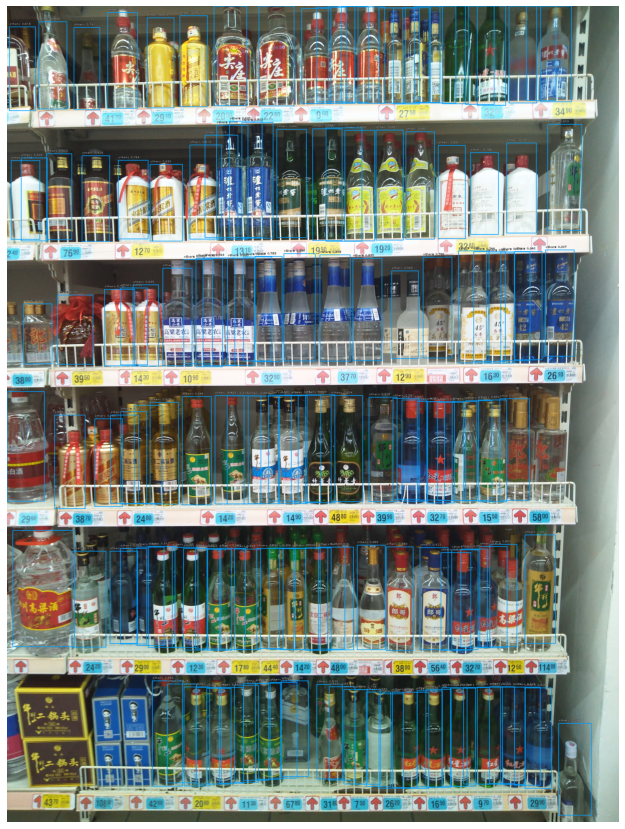

True

In [18]:
# load image
image = read_image_bgr('test_1.jpg')

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# process image
start = time.time()
boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# correct for image scale
boxes /= scale

# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0.5:
        break
        
    color = label_color(label)
    
    b = box.astype(int)
    draw_box(draw, b, color=color)
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(draw, b, caption)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

# 保存结果图
cv2.imwrite("test_1_result.jpg", draw)

## 检测抠小图

In [14]:
# load image
image = read_image_bgr('test_1.jpg')

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# process image
start = time.time()
boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# correct for image scale
boxes /= scale

idx = 0
# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0.5:
        break

    b = box.astype(int)        
    cropped = draw[b[1]:b[3], b[0]:b[2]]
    if cropped is not None:
        cv2.imwrite(f"data/classified_raw/{idx}.jpg", cropped)    
    idx+=1

processing time:  0.13347196578979492
